# <center> 【Kaggle】Telco Customer Churn 电信用户流失预测案例

## <font face="仿宋">第三部分导读

&emsp;&emsp;<font face="仿宋">在案例的第二部分中，我们详细介绍了常用特征转化方法，其中有些是模型训练之必须，如自然数编码、独热编码，而有些方法则是以提高数据质量为核心、在大多数时候都是作为模型优化的备选方法，如连续变量分箱、数据标准化等。当然，在此之后，我们首先尝试构建一些可解释性较强的模型来进行用户流失预测，即采用逻辑回归和决策树模型来进行预测，并同时详细介绍了两种模型在实战中的调优技巧，在最终模型训练完成后，我们也重点讨论了关于两种可解释性模型建模结果的解释方法。

&emsp;&emsp;<font face="仿宋">从理论上来说，树模型的判别能力是要强于逻辑回归的，但在上一节最后的建模结果中我们发现两个模型的建模并无显著差别，预测准确率都维持在79%-80%之间，这或许说明很多逻辑回归无法正确判别的样本决策树模型也无法判别，据此我们推测，这是一个“入门容易、精通较难”的数据集。当然，如果我们进一步尝试其他“更强”的集成学习算法，如随机森林、XGB、CatBoost等，在当前数据集上的建模结果和逻辑回归也并无太大差异，因此我们亟需通过特征工程方法进一步提升数据集质量，进而提升最终模型效果。

&emsp;&emsp;<font face="仿宋">当然，哪怕是复杂模型在当前数据集上表现出了更好的效果，采用特征工程方法提升数据质量仍是优化建模结果必不可少的部分，正如时下流行的描述那样，“数据质量决定模型上界，而建模过程只是不断逼近这个上界”，特征工程中的一系列提高数据质量的方法、无论是在工业界实践中还是各大顶级竞赛里，都已然成了最为重要的提升模型效果的手段。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gwllgk4wgqj31hr0u0wh4.jpg" alt="image-20211112170651500" style="zoom:15%;" />

&emsp;&emsp;<font face="仿宋">不过，所谓的通过特征工程方法提高数据质量，看似简单但实际操作起来却并不容易。其难点并不在于其中具体操作方法的理解，至少相比机器学习算法原理，特征工程的很多方法并不复杂，特征工程的最大难点在于配合模型与数据进行方法选择、以及各种方法的工程化部署实现。一方面，特征工程方法众多，需要根据实际情况“因地制宜”，但数据的情况千变万化，很多时候需要同时结合数据探索结论、建模人员自身经验以及对各种备选方法的熟悉程度，才能快速制定行之有效的特征工程策略；另一方面，很多特征工程方法不像机器学习算法有现成的库可以直接调用，很多方法、尤其是一些围绕当前数据集的定制方法，需要自己手动实现，而这个过程就对建模人员本身的代码编写能力及工程部署能力提出了更高的要求。总而言之，特征工程是一个实践高度相关的技术，这也是为何课程会在介绍案例的过程中同步介绍特征工程常用方法的原因。

&emsp;&emsp;<font face="仿宋">当然，从宽泛的角度来看，所有围绕数据集的数据调整工作都可以看成是特征工程的一部分，包括此前介绍的缺失值填补、数据编码、特征变换等，这些方法其实都能一定程度提升数据质量，而本节开始，我们将花费一整节的时间来讨论另一类特征工程方法：特征衍生与特征筛选。而该方法通过创建更多特征来提供更多捕捉数据规律的维度，从而提升模型效果。当然特征衍生也是目前公认的最为有效的、能够显著提升数据集质量方法。

# <center>Part 3.特征衍生与特征筛选     

&emsp;&emsp;本节开始，我们将进入到特征筛选部分内容。首先我们需要将必要的库进行导入：

In [1]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

from tqdm import tqdm

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *
# 导入特征衍生模块
import features_creation as fc
from features_creation import *

# re模块相关
import inspect, re

# 其他模块
from tqdm import tqdm
import gc

&emsp;&emsp;然后执行Part 1中的数据清洗相关工作：

In [2]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
 
# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化 
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [3]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

&emsp;&emsp;同时，创建自然编码后的数据集以及经过时序特征衍生的数据集：

In [4]:
# 划分训练集和测试集
train, test = train_test_split(tcc, random_state=23)

X_train = train.drop(columns=[ID_col, target]).copy()
X_test = test.drop(columns=[ID_col, target]).copy()

y_train = train['Churn'].copy()
y_test = test['Churn'].copy()

X_train_seq = pd.DataFrame()
X_test_seq = pd.DataFrame()

# 年份衍生
X_train_seq['tenure_year'] = ((72 - X_train['tenure']) // 12) + 2014
X_test_seq['tenure_year'] = ((72 - X_test['tenure']) // 12) + 2014

# 月份衍生
X_train_seq['tenure_month'] = (72 - X_train['tenure']) % 12 + 1
X_test_seq['tenure_month'] = (72 - X_test['tenure']) % 12 + 1

# 季度衍生
X_train_seq['tenure_quarter'] = ((X_train_seq['tenure_month']-1) // 3) + 1
X_test_seq['tenure_quarter'] = ((X_test_seq['tenure_month']-1) // 3) + 1

# 独热编码
enc = preprocessing.OneHotEncoder()
enc.fit(X_train_seq)

seq_new = list(X_train_seq.columns)

# 创建带有列名称的独热编码之后的df
X_train_seq = pd.DataFrame(enc.transform(X_train_seq).toarray(), 
                           columns = cate_colName(enc, seq_new, drop=None))

X_test_seq = pd.DataFrame(enc.transform(X_test_seq).toarray(), 
                          columns = cate_colName(enc, seq_new, drop=None))

# 调整index
X_train_seq.index = X_train.index
X_test_seq.index = X_test.index

In [5]:
ord_enc = OrdinalEncoder()
ord_enc.fit(X_train[category_cols])

X_train_OE = pd.DataFrame(ord_enc.transform(X_train[category_cols]), columns=category_cols)
X_train_OE.index = X_train.index
X_train_OE = pd.concat([X_train_OE, X_train[numeric_cols]], axis=1)

X_test_OE = pd.DataFrame(ord_enc.transform(X_test[category_cols]), columns=category_cols)
X_test_OE.index = X_test.index
X_test_OE = pd.concat([X_test_OE, X_test[numeric_cols]], axis=1)

## <center>Ch.2 基于模型的特征筛选

- 特征的粗筛与精选

&emsp;&emsp;本节开始我们将进一步介绍借助模型进行特征筛选的方法。相比上一小节介绍的特征评价指标，带入模型的特征筛选会更加耗费计算资源，但同时也会更加精准。这些基于模型的特征筛选的实际应用场景有两方面，其一是围绕小规模数据集，进行精准的特征筛选（例如逐个特征进行筛选）；其二则是针对大规模数据集，配合上一小节的特征评价指标，共同进行特征筛选，这个过程往往是特征评价指标进行粗筛、而模型特征筛选进行更精细的特征筛选。

&emsp;&emsp;不过需要注意的是，本节介绍的基于模型的特征筛选方法并不是传统意义上Wrapper或者Embedding方法，或者说并不会按照Wrapper或者Embedding方法对本节内容进行分类。严格意义上来说，Wrapper或者Embedding也更多指的是特征筛选的思路，而如果本节的方法有和Wrapper或Embedding类似的思路，也会在遇到的时候详细说明。这里我们可以先回顾下Wrapper方法和Embedding方法。

- Wrapper和Embedding方法的基本思想

&emsp;&emsp;和上一小节介绍的特征评估指标不同，Wrapper方法和Embedding方法都需要借助模型来完成特征筛选。并且这两种方法的底层思想也是相通的，即认为原始特征矩阵中存在一个最优特征子集（注意是特征的子集、而不是样本子集），找到这个最优子集就能在保证模型效果的同时完成特征筛选。需要注意的是，这里所谓的“最优”指的是模型效果最好，而如果这个子集是真子集（即最优子集特征数量比原始数据集特征数量少），则相当于是进行了特征筛选。例如，一个有10个特征的数据集，通过某种方式我们发现，带入其中3个特征能够让模型效果最好，则完全可以剔除剩余7个特征，并且在这个过程中我们还训练了一个最优模型。

&emsp;&emsp;而在具体方法选取层面，Wrapper选择了一种更容易理解、但要耗费更大计算量的方式，即将这个寻找最优子集的问题转化为了一个搜索问题，即原始特征集存在有限多个子集，我们完全可以在这些子集中逐个搜索，筛选出最优的那个子集；而Embedding则是从算法原理层面入手，寻找某些能够在模型训练过程中同步进行特征筛选的模型（例如决策树和带正则化项的逻辑回归），此时就能一次性带入全部特征，然后伴随模型训练完成，特征筛选也同步完成。

- 特征筛选的重要性

&emsp;&emsp;而关于特征筛选的重要性，此前我们只是强调，过多的特征会影响模型的训练速度，但实际上，冗余无用的特征也是会影响最终模型结果的，尤其是决策树以及以树模型为基础的集成学习。

&emsp;&emsp;其实从严格的算法原理层面来说，冗余无用的特征是并不会影响树模型的建模流程的，但包括sklearn在内的诸多机器学习框架，为了更快速的找到合适的树模型的生长切分点，往往会采用一种更加模糊的搜索方式，也就是说，每次树的生长并不一定是选择那个最优的切分点，而此时，冗余无用的特征就会影响最终模型预测结果。也就是说，某些时候，模型会选择冗余无用特征提供的次优切分点进行树的生长。

&emsp;&emsp;尽管冗余特征对精度的影响并不会特别大，往往也就是在万分位上的差别，但在很多追求模型精度的场景下，万分位的差距也是很大的优化空间。因此对特征进行筛选，就不仅仅是一项提高模型训练速度的事项，更是一项提升模型结果的策略，也就是一项模型优化的策略。其重要性不言而喻。

> 其实对于telco数据集来说，删除部分原始特征，反而会得到一个更好的结果

- 可解释性优先 vs 模型效果优先

&emsp;&emsp;此外，需要说明的是，为何会出现小规模数据集和大规模数据分别使用不同特征筛选策略的问题，表面上看，面对小规模数据集，例如一个只有10个特征的数据集，在建模过程中我们当然是希望能够精准的选出能让模型效果最好的n个特征，因此可以考虑采用模型来进行特征筛选，但是我们同时知道，进行一定程度的特征衍生是能够有效提升模型效果的，而阻止我们针对当前数据集进行特征衍生，将其从小样本数据集变成“大数据集”的根本原因，往往就是模型本身的可解释性。

&emsp;&emsp;我们知道，从算法大类上来分，机器学习和传统的统计分析有较大的区别，但哪怕是在机器学习算法范畴内，也往往存在两种不同的建模场景，这其中的区别就在于到底是追求模型可解释性还是模型效果。有的时候模型可解释性的优先级高于模型效果，则会优先考虑使用线性方程、决策树等解释性较强的模型，此时模型准确率只是第二优先级，在选定了这些模型后再尽可能的进行结果层面的优化，我们称其为构建可解释性优先的机器学习建模；第二种情况则是优先考虑最终模型预测效果，即模型效果优先级高于模型可解释性，此时我们往往会考虑目前实践效果最好的集成学习配合模型融合方法进行建模，此时我们称其为结果优先的机器学习建模。

&emsp;&emsp;很明显，目的不同、所采用的模型不同、特征筛选的策略方法也会有很大的不同。一般来说可解释性优先的建模场景往往出现在业务主导的工作场景中，采用可解释性模型的根本原因也往往是为了给非算法专业人员解释、从而增加模型结果认可度。由于此时的模型以线性方程和决策树为主，这些模型对特征容忍度并不高，因此在特征衍生环节我们会优先考虑手动特征衍生（或者批量特征衍生后寻找可解释性较强的特征），而在特征筛选环节则会考虑使用更加精细的方法，尽可能提高模型效果。但整个过程受可解释性条件束缚，无法发挥机器学习真正的威力。而如果是结果优先的机器学习建模，则更多的出现在算法主导的工作场景中，此时所作的一切为了模型结果（及泛化能力）。由于此时我们会更倾向于采用集成学习+模型融合的方法，集成学习对特征容忍度相对较高、并且很多融合过程都希望训练出“和而不同”的模型，此时我们甚至可以考虑在训练不同的集成算法时、带入相似但不同的数据。很明显，此时在特征衍生过程也可以更加激进、执行批量特征衍生，然后在特征筛选环节可能也不必进行过于精准的特征筛选，核心需要考虑的是如何在效果和效率上做出平衡。

&emsp;&emsp;也就是说，建模目的其实往往和特征工程的方法直接相关。而本小结的内容，在介绍模型特征筛选的方法的同时，也会介绍针对不同场景的筛选策略。

## 一、基于模型的特征评估指标

&emsp;&emsp;在基于模型的特征筛选过程中，最简单也是最通用的方法就是根据模型的训练结果对特征进行评估，而我们知道，很多模型在训练完成时就能同步产出特征重要性指标，例如线性方程中的自变量系数coef_、决策树（及基于树模型的集成学习）中的feature_importances_等，都是可以用于特征评估的指标，这些指标往往代表着特征对当前模型训练的贡献程度，通过这些指标，我们也能观察到特征的重要性，进而辅助我们进行特征筛选。

- 线性方程中的coef_

&emsp;&emsp;首先先看线性方程中的自变量系数，也就是coef_参数。包括线性回归、Lasso、岭回归和逻辑回归在内，线性方程中的自变量系数都是衡量特征重要性的关键指标，自变量系数的绝对值越大、则说明自变量对因变量的取值影响越大、该特征也就越重要。这点在Part 2的逻辑回归模型结果解释部分有详细讨论，此处不做赘述。

- 决策树模型中的feature_importances_

&emsp;&emsp;相比线性方程，决策树及基于决策树的集成算法无疑是目前机器学习使用更广、效果更好的算法，因此相比coef_，feature_importances_指标也会频繁的被使用到，并且feature_importances_的本质是特征对标签取值区分度的累计结果，能够衡量包括线性相关在内的任意类型关系（类似于MI值），因此也是一种更加普适的评估指标。

&emsp;&emsp;不过这些指标看似简单，但实际应用起来却绝不仅仅是根据评分由高到低筛选特征这么简单，因此我们有必要再次回顾feature_importances_的计算流程即计算特性，并据此探究如何应用这些指标进行特征筛选。本节以feature_importances_为例来进行讲解，coef_指标的使用过程也是类似。

### 1.feature_importances_的计算过程

&emsp;&emsp;这里我们首先通过一组极简的数据，先来探讨决策树feature_importances_指标的计算过程。

In [6]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until al

In [7]:
# 准备数据集
X = np.array([[1, 1], [2, 2], [2, 1], [1, 2], [1, 1], [1, 2], [1, 2], [2, 1]])
X = pd.DataFrame(X, columns=['x0', 'x1'])
y = np.array([0, 0, 0, 1, 0, 1, 1, 0])

X,y

(   x0  x1
 0   1   1
 1   2   2
 2   2   1
 3   1   2
 4   1   1
 5   1   2
 6   1   2
 7   2   1,
 array([0, 0, 0, 1, 0, 1, 1, 0]))

[Text(0.4, 0.8333333333333334, 'X[1] <= 1.5\ngini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.6, 0.5, 'X[0] <= 1.5\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

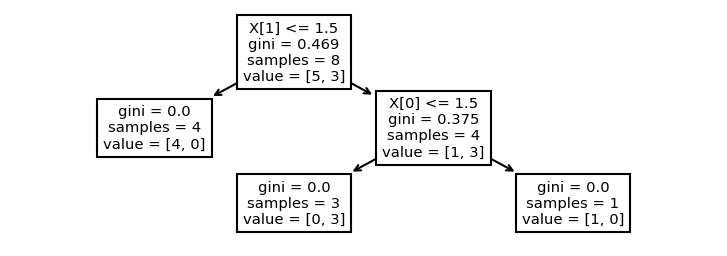

In [8]:
clf = DecisionTreeClassifier().fit(X, y)
plt.figure(figsize=(6, 2), dpi=150)
tree.plot_tree(clf)

模型训练完后，我们可以查看两个特征的重要性指标：

In [9]:
clf.feature_importances_

array([0.4, 0.6])

而feature_importances_到底是如何计算的呢？这里我们仍然可以回归sklearn的源码来进行查看：

<center><img src="https://s2.loli.net/2022/04/15/RNElsyd6h5uMKHV.png" alt="image-20220415164435395" style="zoom:50%;" />

这是段cython代码，和Python代码略有差异。但从importance对象的创建过程，仍然能看出其基本计算流程。首先importances是一个累计结果，决策树每生长一次就会进行一次importances的计算，即计算一次本次生长中标签不纯度下降数值，并将其累计到本次生长对应的特征的重要性中。而这里的一次生长过程中不纯度下降值，并不是遵照上一小节的信息增益的计算流程，而是父节点的权重\*父节点的标签不纯度，减去左右两边子节点的权重\*子节点标签不纯度，这里父节点、子节点的权重就是各数据集样本数在总样本中的占比。例如上述x0、x1两个特征的重要性可以参照如下过程进行计算：

In [10]:
FI_x0 = (4 * 0.375) / 8
FI_x1 = (8 * 0.469 - 4 * 0.375) / 8

FI_x0, FI_x1

(0.1875, 0.2815)

并且为了方便比较，决策树最终输出的feature_importances_实际上是不同特征重要性的占比，即：

In [11]:
FI_x0/(FI_x0+FI_x1), FI_x1/(FI_x0+FI_x1)

(0.39978678038379534, 0.6002132196162047)

### 2.feature_importances_的计算特性

&emsp;&emsp;在熟悉了feature_importances_的计算流程后，接下来进一步讨论基于该流程、feature_importances_所展示出的计算特性。

- feature_importances_的随机性

&emsp;&emsp;首先需要注意的是，如果数据集更加复杂，则feature_importances_值在实际计算过程中将表现出一定程度的随机性。例如带入telco数据集进行建模，则会得到如下结果：

In [12]:
clf = DecisionTreeClassifier().fit(X_train_OE, y_train)
clf.feature_importances_

array([0.02727689, 0.01658065, 0.02058534, 0.01486696, 0.00308123,
       0.01510983, 0.02463827, 0.04888942, 0.01590034, 0.01387519,
       0.01621799, 0.00947659, 0.01659499, 0.17219693, 0.02503379,
       0.04672867, 0.09925022, 0.18879121, 0.22490549])

In [13]:
s1 = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
s1

TotalCharges        0.224905
MonthlyCharges      0.188791
Contract            0.172197
tenure              0.099250
OnlineSecurity      0.048889
PaymentMethod       0.046729
gender              0.027277
PaperlessBilling    0.025034
InternetService     0.024638
Partner             0.020585
StreamingMovies     0.016595
SeniorCitizen       0.016581
TechSupport         0.016218
OnlineBackup        0.015900
MultipleLines       0.015110
Dependents          0.014867
DeviceProtection    0.013875
StreamingTV         0.009477
PhoneService        0.003081
dtype: float64

In [14]:
clf = DecisionTreeClassifier().fit(X_train_OE, y_train)
clf.feature_importances_

array([0.02615012, 0.01897285, 0.02160852, 0.01841412, 0.00340157,
       0.01472038, 0.0244306 , 0.04968895, 0.01821232, 0.0122789 ,
       0.01896473, 0.00943813, 0.01733306, 0.17219693, 0.02458266,
       0.04597754, 0.10512561, 0.17516754, 0.22333546])

In [15]:
s2 = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
s2

TotalCharges        0.223335
MonthlyCharges      0.175168
Contract            0.172197
tenure              0.105126
OnlineSecurity      0.049689
PaymentMethod       0.045978
gender              0.026150
PaperlessBilling    0.024583
InternetService     0.024431
Partner             0.021609
SeniorCitizen       0.018973
TechSupport         0.018965
Dependents          0.018414
OnlineBackup        0.018212
StreamingMovies     0.017333
MultipleLines       0.014720
DeviceProtection    0.012279
StreamingTV         0.009438
PhoneService        0.003402
dtype: float64

In [16]:
clf = DecisionTreeClassifier().fit(X_train_OE, y_train)
clf.feature_importances_

array([0.02222983, 0.02118631, 0.02476213, 0.01671562, 0.00322323,
       0.01408272, 0.02620733, 0.04766841, 0.01702756, 0.01174515,
       0.01968234, 0.01017574, 0.01486987, 0.17219693, 0.02682492,
       0.0394415 , 0.10560986, 0.19018292, 0.21616765])

In [17]:
s3 = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
s3

TotalCharges        0.216168
MonthlyCharges      0.190183
Contract            0.172197
tenure              0.105610
OnlineSecurity      0.047668
PaymentMethod       0.039442
PaperlessBilling    0.026825
InternetService     0.026207
Partner             0.024762
gender              0.022230
SeniorCitizen       0.021186
TechSupport         0.019682
OnlineBackup        0.017028
Dependents          0.016716
StreamingMovies     0.014870
MultipleLines       0.014083
DeviceProtection    0.011745
StreamingTV         0.010176
PhoneService        0.003223
dtype: float64

当然此时由于没有进行超参数搜索，模型暂时处于严重过拟合状态：

In [18]:
clf.score(X_train_OE, y_train), clf.score(X_test_OE, y_test)

(0.9982960999621355, 0.7353776263486655)

不过这并不影响我们对feature_importances_表现出随机性的探讨。首先我们能够发现，相同参数的决策树模型，在多次训练时feature_importances_会表现出一定的随机性，但这种随机性大多数情况下只是小幅扰动，只在个别情况下才会影响特征重要性排名：

In [19]:
df_temp = pd.DataFrame({'tree-s1':s1.index, 'tree-s2':s2.index, 'tree-s3':s3.index})
df_temp

,tree-s1,tree-s2,tree-s3
0,TotalCharges,TotalCharges,TotalCharges
1,MonthlyCharges,MonthlyCharges,MonthlyCharges
2,Contract,Contract,Contract
3,tenure,tenure,tenure
4,OnlineSecurity,OnlineSecurity,OnlineSecurity
5,PaymentMethod,PaymentMethod,PaymentMethod
6,gender,gender,PaperlessBilling
7,PaperlessBilling,PaperlessBilling,InternetService
8,InternetService,InternetService,Partner
9,Partner,Partner,gender


不过尽管如此，我们也需要知道这种随机性的来源。通过查看DecisionTreeClassifier的random_state参数解释不难发现，这种随机性源于CART树对切分点的选取。根据评估器的说明，哪怕是max_features=n_features（即每次训练带入全部特征、而max_features<n_features时则每次切分带入部分特征、此时随机性更强），在进行决策树生长时也经常遇到拥有相同效力的备选切分点（即基于基尼系数的信息增益相同），此时只能随机挑选其中一个备选点进行切分，而选取哪个切分点，就必然给对应的特征累计更多的重要性。这也就是为何相同的数据在多次建模时特征重要性会各不相同的原因。

> 这种不确定性其实也是feature_importances_指标的缺陷，相比卡方值、方差分析结果和互信息值等更加严谨计算过程，feature_importances_甚至不能看成是严格意义的特征评分方法。

&emsp;&emsp;尽管有随机性干扰，我们还是能从feature_importances_的结果中粗略的判断各个特征的重要性的，例如在上述建模过程中两个连续变量，即TotalCharges和MonthlyCharges表现不俗，相对来说，StreamingTV、PhoneService等特征并没有对模型效果提升做出太大贡献。此外需要注意的是，伴随着数据量（和特征数量）的提升，这种随机性也将会有更大的影响，尤其带入分组统计特征后，大量特征的数值分布都是相同，选哪个特征对标签进行切分都能达到相同的效果，此时这些分组统计的衍生特征的特征重要性将完全由这个随机过程决定；而反之，如果本身数据量较小，则不会存在不同特征的不同切分点都能达到相同效果这一情况，此时特征重要性不会出现随机性。

- feature_importances_受建模过程影响

&emsp;&emsp;略微感到奇怪的是，为何上述三组模型都判断两个连续变量的重要性较强、甚至强于Contract、tenure和OnlineSecurity这些特征呢？根据上一小节互信息发的结论，Contract、tenure等字段是要强于两个连续变量的。此处我们可以简单对比上述决策树输出的特征重要性排名和互信息算得的特征重要性排名：

In [20]:
from sklearn.feature_selection import mutual_info_classif

In [21]:
mask = [True]*len(category_cols) + [False]*len(numeric_cols)
mask

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False]

In [22]:
MI = mutual_info_classif(X_train_OE, y_train, discrete_features=mask, random_state=22)
MI

array([2.51869556e-05, 1.23816755e-02, 1.12934840e-02, 1.44750232e-02,
       2.29431150e-05, 5.93559150e-04, 5.44435344e-02, 6.73003276e-02,
       4.99549593e-02, 4.58322554e-02, 6.38268975e-02, 3.31442443e-02,
       3.33677529e-02, 1.01588946e-01, 1.95195236e-02, 4.64175293e-02,
       6.56956879e-02, 5.14837211e-02, 4.64057620e-02])

In [23]:
s4 = pd.Series(MI, index=clf.feature_names_in_).sort_values(ascending=False)
s4

Contract            0.101589
OnlineSecurity      0.067300
tenure              0.065696
TechSupport         0.063827
InternetService     0.054444
MonthlyCharges      0.051484
OnlineBackup        0.049955
PaymentMethod       0.046418
TotalCharges        0.046406
DeviceProtection    0.045832
StreamingMovies     0.033368
StreamingTV         0.033144
PaperlessBilling    0.019520
Dependents          0.014475
SeniorCitizen       0.012382
Partner             0.011293
MultipleLines       0.000594
gender              0.000025
PhoneService        0.000023
dtype: float64

In [24]:
df_temp['MI'] = s4.index
df_temp

,tree-s1,tree-s2,tree-s3,MI
0,TotalCharges,TotalCharges,TotalCharges,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity
2,Contract,Contract,Contract,tenure
3,tenure,tenure,tenure,TechSupport
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges
9,Partner,Partner,gender,DeviceProtection


能够发现，二者结果存在较大差异，那树模型的结果和MI的结果哪个更“可信”呢？这里就需要回到我们特征评估的最终目的。所有的特征评估其实都是为了找到一组能够更好的帮助模型提升结果和泛化能力的特征，而此时树模型的特征重要性计算结果，其实是在模型过拟合状态下算得得，其结果可信度并不高。

&emsp;&emsp;回想树模型的特征重要性计算过程我们不难发现，该指标的计算是和当前建模流程直接挂钩的，建模流程不同、选取的切分点不同、最后算得的特征重要性也各不相同。而当前的三个树模型，实际上是严重过拟合的，也就是说在过拟合情况下，两个连续变量重要性是要强于Contract和tenure的，但如果我们是希望训练一个泛化能力更强的模型，上述特征强弱结论就不一定成立了。

&emsp;&emsp;接下来我们尝试围绕决策树进行超参数优化，在保证模型泛化能力情况下，再查看各特征重要性。这里就采用网格搜索进行调参，基本流程如下：

In [25]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [26]:
# 实例化网格搜索评估器
tree_search = GridSearchCV(estimator = tree_model,
                           param_grid = tree_param,
                           n_jobs = 12)

In [27]:
tree_search.fit(X_train_OE, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [28]:
# 查看最优参数组
tree_search.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [29]:
# 查看验证集准确率均值
tree_search.best_score_

0.7925029027264128

In [30]:
# 查看训练集整体准确率
tree_search.score(X_train_OE, y_train)

0.8014009844755774

In [31]:
# 查看测试集准确率
tree_search.score(X_test_OE, y_test)

0.7938671209540034

能够看出，此时模型的过拟合倾向已经得到了有效抑制。此时再查看各特征的重要性结果如下：

In [32]:
tree_search.best_estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07893377, 0.14119719, 0.        , 0.        ,
       0.        , 0.        , 0.02460464, 0.55635763, 0.        ,
       0.00930132, 0.11528793, 0.02646592, 0.0478516 ])

In [33]:
tree_search.best_estimator_.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [34]:
ss = pd.Series(tree_search.best_estimator_.feature_importances_, index=tree_search.best_estimator_.feature_names_in_).sort_values(ascending=False)
ss

Contract            0.556358
OnlineSecurity      0.141197
tenure              0.115288
InternetService     0.078934
TotalCharges        0.047852
MonthlyCharges      0.026466
StreamingMovies     0.024605
PaymentMethod       0.009301
StreamingTV         0.000000
PaperlessBilling    0.000000
gender              0.000000
TechSupport         0.000000
SeniorCitizen       0.000000
OnlineBackup        0.000000
MultipleLines       0.000000
PhoneService        0.000000
Dependents          0.000000
Partner             0.000000
DeviceProtection    0.000000
dtype: float64

In [35]:
df_temp['tree-search'] = ss.index
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity
2,Contract,Contract,Contract,tenure,tenure
3,tenure,tenure,tenure,TechSupport,InternetService
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling


能够发现，最终特征重要性排名和MI结果较为接近（需要注意，StreamingTV后所有特征重要性都为0、也就是完全没有带入进行建模，这些重要性都是0的特征排名部分先后）。

&emsp;&emsp;并且，此处如果多次反复执行上述过程，特征重要性排序并不会发生任何变化。这也说明带入交叉验证过程的模型训练，能够获得一个更加稳定的建模过程（树生长的过程）以及特征重要性评估结果。并且通过交叉比对MI的计算结果，也能够发现该结果会更加可信。综上所述，feature_importances_是一个和树模型建模过程高度关联的指标，并且模型结果越好，该指标就越可信。

### 3.基于feature_importances_的特征筛选

&emsp;&emsp;这里我们进一步聚焦上述决策树最后输出的feature_importances_为0的部分特征。需要注意的是，0值表面代表这些特征重要性为0，但根据feature_importances_的计算过程，feature_importances_取值为0实际上代表的是这些特征没有为决策树生长过程提供任何一个有效的切分点，即决策树的生长过程并没有用到这些特征，换而言之，我们把这些特征删除也不会影响最终建模结果：

In [36]:
mask = tree_search.best_estimator_.feature_importances_ != 0
mask

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True])

In [37]:
tree_search.best_estimator_.feature_names_in_[mask]

array(['InternetService', 'OnlineSecurity', 'StreamingMovies', 'Contract',
       'PaymentMethod', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [38]:
X_train_OE_part = X_train_OE[tree_search.best_estimator_.feature_names_in_[mask]]

In [39]:
X_train_OE_part.head()

,InternetService,OnlineSecurity,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,TotalCharges
1936,0.0,2.0,0.0,1.0,0.0,51,60.50,3145.15
6999,0.0,2.0,0.0,0.0,3.0,3,35.45,106.85
5863,1.0,0.0,2.0,0.0,2.0,21,97.35,2119.50
131,0.0,2.0,2.0,0.0,1.0,25,58.60,1502.65
3015,0.0,2.0,2.0,2.0,2.0,59,86.75,5186.00


In [40]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,25, 1).tolist()}

In [41]:
# 实例化网格搜索评估器
tree_search1 = GridSearchCV(estimator = tree_model,
                            param_grid = tree_param,
                            n_jobs = 12)

In [42]:
tree_search1.fit(X_train_OE_part, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19, 20, 21, 22, 23, 24],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [43]:
# 查看特征子集的建模结果
tree_search1.best_score_

0.7947763467217108

In [44]:
tree_search1.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 6,
 'max_leaf_nodes': 19,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [45]:
# 查看原始特征的建模结果
tree_search.best_score_

0.7925029027264128

In [46]:
tree_search1.best_estimator_.feature_importances_

array([0.07662396, 0.13706538, 0.02388465, 0.54007714, 0.00902914,
       0.1188095 , 0.03953651, 0.05497371])

能够看出，在剔除了无关特征后，不但没有影响建模结果，最后的准确率甚至有所提升。当然根据此前的实践情况，很多时候特征都是“过犹不及”，而上述过程其实就是一个通过feature_importances_进行特征筛选、然后提升模型效果的完整过程。并且由于该特征筛选过程直接和模型效果挂钩，最终特征剔除的结果也是显而易见的。而“剔除无关特征会提升模型效果”，也是为何要执行特征筛选的根本原因。

> 对于sklearn的CART树来说，出现剔除部分特征后模型效果反而上升的原因，其实还是在于CART树切分点选取的随机性上，尽管CART树的原理要求遍历所有可能切分点然后寻找最优切分点，但实际代码执行过程中会小幅牺牲精度以换取执行效率，即这个对比的过程是一个粗精度的对比过程。而当特征减少后，需要对比的备选切分点数量明显减少，尽管仍然是粗精度的对比，但备选切分点的减少使得干扰项也随之减少，进而能够小幅提升效果。

&emsp;&emsp;当然，对于这个特征筛选过程，也有几点需要注意，首先是模型层面，为了提供更加可信的feature_importances_结果，模型训练一定要借助交叉验证或者超参数优化器共同执行、以训练一个泛化能力更强的模型；其次是运算效率方面，很明显，带入模型的特征筛选过程需要耗费更大的算力，往往更加适合于小范围高精度的特征筛选；其三，这个特征筛选过程其实已经有Embedding的影子在里面了，在训练模型的同时筛选出了一组有效特征，如果第一次训练的模型就是最优模型、并且特征子集就是最优子集，则上述过程就是一个完整的Embedding过程。

&emsp;&emsp;此外，上述结果还涉及一个非常重要的议题，那就是单独一颗决策树能够利用特征的最大个数问题。其实决策树的结构和决策树能够利用的特征个数是直接相关的，一颗两层的二叉决策树只有一个切分点、最多只能用到一个特征，而一个三层的二叉树则有3个切分点，最多也只能用到三个特征。尽管对于单独一棵决策树来说当前用到的特征一定就是模型训练的最优解，但对于集成学习或者模型融合过程，特征的利用程度却是影响模型效果的重要因素，这点我们会在后面详细讨论。

&emsp;&emsp;不过，根据上述结果我们能够很自然的进行联想，那就是我们剔除了feature_importances_=0的特征，最终模型效果得以上升，那如果再剔除一些feature_importances_=0较小的特征，模型结果是否会进一步上升呢？这个问题其实就等价于，当前X_train_OE_part数据集是不是最优子集。要解决这个问题，就需要借助更进一步的搜索方法来解决，也就是所谓的递归消除法（Recursive feature elimination）。

## 二、特征递归消除法 Recursive feature elimination（RFE）

### 1.经典递归消除法RFE

#### 1.1 RFE的基本计算过程

&emsp;&emsp;RFE是一种基于模型训练结果进行特征筛选的方法，并且是一种通过递归不断消除无用特征的方法。该方法的基本执行步骤如下：

- Step 1：根据给定的评估器，在当前数据集A1上进行训练并计算每个特征的重要性，即计算每个特征的coef_或feature_importances_；
- Step 2：剔除最不重要的特征，即特征重要性计算结果最小的特征，得到特征子集A2，然后再次训练模型，并计算剩余特征的特征重要性；
- Step 3：不断重复Step 2，直到特征子集的个数等于n_features_to_select，其中n_features_to_select是人工设置的最终保留特征个数。

&emsp;&emsp;不难发现，相比只训练一个模型、然后根据这个模型的feature_importances_对特征重要性进行排名，RFE过程会更加复杂同时也会更加精准，这种精准体现在每次剔除特征后，剩下的特征都是在新环境中进行比较，当然RFE过程由于会涉及到多轮模型训练，需要耗费的计算量肯定也更大。

#### 1.2 RFE在sklearn中的实现

&emsp;&emsp;同样，我们可以在sklearn中的feature_selection模块中找到RFE评估器：

In [47]:
from sklearn.feature_selection import RFE

- RFE的调用方法

&emsp;&emsp;首先是RFE评估器，该评估器的参数结构并不复杂，基本解释如下：

| 参数 | 解释 | 说明 |
| ------ | ------ | ------ |
| estimator | 带入训练的评估器 | 必须要能输出特征重要性指标 |
| n_features_to_select | 筛选后特征个数 | 默认保留一半 |
| step | 每次剔除特征的个数 | 默认每轮剔除1个特征 |
| importance_getter | 特征重要性评估指标 | 默认情况是coef_或者feature_importances_ |

In [48]:
RFE?

Init signature:
RFE(
    estimator,
    *,
    n_features_to_select=None,
    step=1,
    verbose=0,
    importance_getter='auto',
)
Docstring:     
Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the
coefficients of a linear model), the goal of recursive feature elimination
(RFE) is to select features by recursively considering smaller and smaller
sets of features. First, the estimator is trained on the initial set of
features and the importance of each feature is obtained either through
any specific attribute or callable.
Then, the least important features are pruned from current set of features.
That procedure is recursively repeated on the pruned set until the desired
number of features to select is eventually reached.

Read more in the :ref:`User Guide <rfe>`.

Parameters
----------
estimator : ``Estimator`` instance
    A supervised learning estimator with a ``fit`` method that provides
    information about

接下来尝试使用该评估器进行特征递归消除：

In [49]:
# 实例化评估器
tree_rfe = DecisionTreeClassifier()
rfe = RFE(estimator=tree_rfe)

In [50]:
rfe.fit(X_train_OE, y_train)

RFE(estimator=DecisionTreeClassifier())

在评估器训练完后，将提供非常细致的特征递归消除的结果。首先是原始特征个数与筛选后保留特征个数：

In [51]:
# 总特征个数
rfe.n_features_in_

19

In [52]:
# 筛选后特征个数
rfe.n_features_

9

并且能够查看最后筛选出来的特征：

In [53]:
rfe.get_support()

array([ True, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True])

In [54]:
rfe.feature_names_in_[rfe.get_support()]

array(['gender', 'InternetService', 'OnlineSecurity', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [55]:
rfe.get_feature_names_out()

array(['gender', 'InternetService', 'OnlineSecurity', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

此外，还能够看到特征的评级（rank），即评级越低的特征就是越不重要的特征，也就是越早被剔除的特征，而rank=1的特征则是最终被保留下来的特征，根据rank的取值，我们也能看出每个被剔除的特征被淘汰的时间。例如rank=11的特征就是首先被淘汰的特征：

In [56]:
rfe.ranking_

array([ 1,  5,  2,  6, 11,  7,  1,  1,  3,  9,  4, 10,  8,  1,  1,  1,  1,
        1,  1])

In [57]:
rfe.ranking_ == 1

array([ True, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True])

In [58]:
(rfe.ranking_ == 1) == rfe.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

&emsp;&emsp;当然，RFE也提供了围绕当前数据筛选结果进行模型评分的相关功能，分别是用于模型预测的.predict方法，以及直接输出模型评估结果的.score方法：

In [59]:
rfe.predict(X_train_OE)

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [60]:
rfe.score(X_train_OE, y_train)

0.9979174555092768

In [61]:
rfe.score(X_test_OE, y_test)

0.7336740488358887

能够看出，由于是带入的未经调参的决策树模型，模型过拟合问题非常明显。此外需要注意的是这里需要带入训练RFE评估器时的全部数据，但实际上上述过程是选取了那些最后被挑选出来的特征带入进行的预测，并非全部数据。上述结果等价于带入选出的特征、在原有模型超参数结构下进行训练并得出的评分：

In [62]:
rfe.get_feature_names_out()

array(['gender', 'InternetService', 'OnlineSecurity', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [63]:
X_train_OE[rfe.get_feature_names_out()]

,gender,InternetService,OnlineSecurity,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
1936,0.0,0.0,2.0,1.0,1.0,0.0,51,60.50,3145.15
6999,1.0,0.0,2.0,0.0,1.0,3.0,3,35.45,106.85
5863,0.0,1.0,0.0,0.0,1.0,2.0,21,97.35,2119.50
131,0.0,0.0,2.0,0.0,1.0,1.0,25,58.60,1502.65
3015,1.0,0.0,2.0,2.0,1.0,2.0,59,86.75,5186.00
...,...,...,...,...,...,...,...,...,...
2998,1.0,1.0,0.0,0.0,1.0,2.0,2,74.75,144.80
1993,0.0,0.0,0.0,0.0,1.0,2.0,1,45.70,45.70
1064,0.0,0.0,2.0,1.0,0.0,3.0,14,55.70,795.15
4838,0.0,1.0,0.0,1.0,1.0,1.0,67,109.70,7344.45


In [64]:
tree_rfe.fit(X_train_OE[rfe.get_feature_names_out()], y_train)
tree_rfe.score(X_train_OE[rfe.get_feature_names_out()], y_train)

0.9979174555092768

#### 1.3 基于RFE计算过程的特征筛选

- RFE计算过程的模型训练问题

&emsp;&emsp;我们知道，只有模型本身有效，模型产出的feature_importances_才具有可信度。RFE过程尽管会用到feature_importances_进行特征筛选，但RFE过程只是对模型进行简单训练，并未进行超参数搜索等模型优化，这会使得每一轮的模型都是过拟合的，而基于过拟合模型产出的feature_importances_进行的特征筛选，结果并不可靠。此处设置n_features_to_select=1，最终会剔除到只剩一个特征：

In [65]:
tree_rfe = DecisionTreeClassifier()
rfe = RFE(estimator=tree_rfe, n_features_to_select=1).fit(X_train_OE, y_train)

In [66]:
rfe.ranking_

array([ 8, 15, 10, 12, 19, 14,  9,  6, 13, 17, 11, 18, 16,  3,  7,  5,  4,
        2,  1])

In [67]:
rfe_res = pd.Series(rfe.feature_names_in_, index=rfe.ranking_)
rfe_res.sort_index(inplace=False)

1         TotalCharges
2       MonthlyCharges
3             Contract
4               tenure
5        PaymentMethod
6       OnlineSecurity
7     PaperlessBilling
8               gender
9      InternetService
10             Partner
11         TechSupport
12          Dependents
13        OnlineBackup
14       MultipleLines
15       SeniorCitizen
16     StreamingMovies
17    DeviceProtection
18         StreamingTV
19        PhoneService
dtype: object

In [68]:
df_temp['rfe_res'] = rfe_res.sort_index(inplace=False).values
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search,rfe_res
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract,TotalCharges
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity,MonthlyCharges
2,Contract,Contract,Contract,tenure,tenure,Contract
3,tenure,tenure,tenure,TechSupport,InternetService,tenure
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges,PaymentMethod
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges,OnlineSecurity
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies,PaperlessBilling
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod,gender
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV,InternetService
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling,Partner


能够发现，根据RFE特征筛选计算得到的特征重要性排名和模型过拟合时输出的feature_importances_结果基本一致。并且根据此前所说决策树的随机性，上述流程多次重复执行，结果肯定也会较为随机。

&emsp;&emsp;要解决该问题，sklearn提供了一个非常便捷的方法，即在实例化RFE评估器时带入一个已经经过网格搜索调参后的模型，即可每一轮特征重要性评估时使用已经训练好的模型，而该模型是已经经过剪枝的决策树模型，不会再表现出过拟合倾向。

In [69]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [70]:
# 实例化网格搜索评估器
tree_search_RFE = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

In [71]:
tree_search_RFE.fit(X_train_OE, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [72]:
tree_search_RFE.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

然后带入已经训练好的决策树模型tree_search_RFE.best_estimator_，需要注意的是，当RFE评估器接收到的是一个已经经过训练好的评估器，则在接下来fit时会沿用该评估器的基本结构（也就是决策树参数）来进行模型训练，也就是上面我们看到的'ccp_alpha'=0.0、'max_depth'=5、'max_leaf_nodes'=14等。

In [73]:
tree_search_RFE.best_estimator_

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=16)

In [74]:
rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=1).fit(X_train_OE, y_train)

In [75]:
rfe_search.ranking_

array([19, 18, 17, 16, 15, 14,  4,  3, 13, 12, 11, 10,  7,  1,  9,  8,  2,
        6,  5])

In [76]:
rfe_res_search = pd.Series(rfe_search.feature_names_in_, index=rfe_search.ranking_)
rfe_res_search.sort_index(inplace=False)

1             Contract
2               tenure
3       OnlineSecurity
4      InternetService
5         TotalCharges
6       MonthlyCharges
7      StreamingMovies
8        PaymentMethod
9     PaperlessBilling
10         StreamingTV
11         TechSupport
12    DeviceProtection
13        OnlineBackup
14       MultipleLines
15        PhoneService
16          Dependents
17             Partner
18       SeniorCitizen
19              gender
dtype: object

In [77]:
df_temp['rfe_res_search'] = rfe_res_search.sort_index(inplace=False).values
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search,rfe_res,rfe_res_search
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract,TotalCharges,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity,MonthlyCharges,tenure
2,Contract,Contract,Contract,tenure,tenure,Contract,OnlineSecurity
3,tenure,tenure,tenure,TechSupport,InternetService,tenure,InternetService
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges,PaymentMethod,TotalCharges
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges,OnlineSecurity,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies,PaperlessBilling,StreamingMovies
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod,gender,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV,InternetService,PaperlessBilling
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling,Partner,StreamingTV


能够发现，此时RFE输出结果会更加接近MI的结果和经过网格搜索后的决策树特征重要性结果，也说明该结果会更加可信。而上述过程就是一个能很好平衡效率和效果的基于模型的筛选过程，同时也是能够同时应用于小样本高精度特征筛选和大量数据高效特征筛选的策略，同时也是我们在面对海量特征时最常用的高精度特征筛选方法。

- RFE高效特征筛选流程

&emsp;&emsp;上述RFE高效特征筛选的流程可以总结如下：

&emsp;&emsp;Step 1.在全量样本上训练一个经过超参数搜索优化后的模型，或者找到一组优化后的超参数；

&emsp;&emsp;Step 2.将这个训练后的模型带入RFE搜索过程，并设置RFE参数n_features_to_select=1，在step=1时，RFE过程将每次剔除当前数据集中最不重要的特征，然后根据输入模型的超参数再次进行模型训练，以此往复，遍历全部特征。

&emsp;&emsp;Step 3.根据RFE评估器的ranking_查看每个特征的重要性排名。

&emsp;&emsp;注意，该过程同时适用于小样本的精准特征重要性评估，同时也适用于海量特征的特征筛选。当特征池拥有海量特征时，假设有一万条特征，则可以抽取其中一千个特征进行模型训练与超参数优化，当然此时可能会更多的采用集成学习。然后将训练好的模型带入RFE过程，按照step=500进行搜索，即每次剔除最不重要的500个特征，并最终保留500个特征（n_features_to_select=500），借此对这一万个特征进行10000/500=20个等级的划分，并根据最终实际情况确定带入后续模型训练环节的特征个数。而这也是目前最为重要的海量特征高精度搜索的策略。

&emsp;&emsp;关于这套策略具体执行方法，我们将在下一小节详细讨论，这里我们仍然需要解决三个原理层面的问题，其一是相比特征评估指标和单模型feature_importances_，RFE的搜索流程为何会更加精准？其二则是我们明明没有在每一轮特征筛选时进行模型调优，我们如何能相信这种不经过调优模型输出的feature_importances_排名呢？其三则是有了特征排名后，我们要如何确定到底选取多少个特征呢？

&emsp;&emsp;我们围绕这几个问题逐一来进行讨论。

- RFE高效特征筛选 vs 特征评估指标 vs 单模型feature_importances_

&emsp;&emsp;首先，带入模型的特征评估由于是和模型直接挂钩，因此最终结果肯定要比特征评估指标更加精准。这也是上一小节的特征评估指标往往用于初筛，而模型特征筛选会用于后期更精准特征筛选的原因。在借助模型评估指标进行特征筛选时，RFE本质上也是借助feature_importances_来进行特征筛选，只不过是在不同特征子集中反复计算feature_importances_，然后每次只输出feature_importances_取值最小的特征作为最终结论。很明显，对于RFE来说，其的容错率会高很多，无论feature_importances_计算数值如何、特征feature_importances_排名如何，只要能判断当前数据集中最弱的特征即可。另外，RFE的这种动态计算feature_importances_的过程，能够很好的对每个特征进行评估，而单模型的feature_importances_只能在当前模型能接受的最大范围内对特征进行评估，特征过多则会出现大量的feature_importances_=0的情况。这点对于单独模型来说问题不大，但对于集成学习的模型融合来说影响巨大，模型融合并不是追求单模型效果最好，而是希望最终通过多个模型，能够更深层都挖掘数据集整体信息，此时对于某个单独模型feature_importances_=0的特征，对于别的模型可能就是提高预测结果的关键。

- 更加严谨的RFE流程

&emsp;&emsp;接下来我们讨论第二个问题，那就是，如果模型不是当前数据集上的最有模型，最终特征评估的可信度是多少呢？这里我们可以做一个实验，即如果每一轮剔除一个特征、并且每一轮都重新训练一个模型并对其进行调优，看下最终特征重要性排名结果是否会发生变化。

&emsp;&emsp;围绕这个目标，我们可以有两种修改方案，其一是修改网格搜索评估器，可以在外层再嵌套一层评估器，增加.feature_importance_属性（调用best_estimator的.feature_importance属性），然后就可以直接带入到RFE的搜索过程中了。相关方法可以参考Part 2中对逻辑回归评估器的修改；其二则是修改计算流程，即每次使得RFE剔除一个特征，然后利用特征子集训练一个最优超参数搜索后的决策树，然后再将这个模型带入下次RFE特征搜索，过程如下：

In [78]:
# 定义参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 创建容器
rfe_res_search1 = []

# 执行循环
for i in tqdm(range(18)):
    
    i = 18 - i
    # 实例化网格搜索评估器
    tree_model = DecisionTreeClassifier()
    tree_search_RFE = GridSearchCV(estimator = tree_model,
                                   param_grid = tree_param,
                                   n_jobs = 12)
    
    # 首次循环时，创建X_train_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()    
        
    # 训练模型，然后带入RFE评估器
    tree_search_RFE.fit(X_train_temp, y_train)
    rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
    X_train_temp = X_train_OE[rfe_search.get_feature_names_out()]    
        
    # 搜索本轮被淘汰的特征，并记入rfe_res_search1
    rfe_res_search1.append(rfe_search.feature_names_in_[rfe_search.ranking_ != 1])
    
# 清除临时变量
gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:41<00:00, 12.32s/it]


4226

注意，这里我们是逐个剔除不重要的特征，并在剩下的特征中、逐轮进行带有超参数搜索的模型训练，由于RFE并不支持在只有1个特征的情况下剔除这个特征，因此总共循环了18次、依次剔除了最不重要的18个特征，当然剩下的特征就是最重要的特征：

In [79]:
rfe_search.get_feature_names_out()

array(['Contract'], dtype=object)

In [80]:
rfe_res_search1

[array(['gender'], dtype=object),
 array(['SeniorCitizen'], dtype=object),
 array(['Partner'], dtype=object),
 array(['Dependents'], dtype=object),
 array(['PhoneService'], dtype=object),
 array(['MultipleLines'], dtype=object),
 array(['OnlineBackup'], dtype=object),
 array(['DeviceProtection'], dtype=object),
 array(['TechSupport'], dtype=object),
 array(['StreamingTV'], dtype=object),
 array(['PaperlessBilling'], dtype=object),
 array(['PaymentMethod'], dtype=object),
 array(['StreamingMovies'], dtype=object),
 array(['MonthlyCharges'], dtype=object),
 array(['TotalCharges'], dtype=object),
 array(['InternetService'], dtype=object),
 array(['tenure'], dtype=object),
 array(['OnlineSecurity'], dtype=object)]

In [81]:
rfe_res_search1[::-1]

[array(['OnlineSecurity'], dtype=object),
 array(['tenure'], dtype=object),
 array(['InternetService'], dtype=object),
 array(['TotalCharges'], dtype=object),
 array(['MonthlyCharges'], dtype=object),
 array(['StreamingMovies'], dtype=object),
 array(['PaymentMethod'], dtype=object),
 array(['PaperlessBilling'], dtype=object),
 array(['StreamingTV'], dtype=object),
 array(['TechSupport'], dtype=object),
 array(['DeviceProtection'], dtype=object),
 array(['OnlineBackup'], dtype=object),
 array(['MultipleLines'], dtype=object),
 array(['PhoneService'], dtype=object),
 array(['Dependents'], dtype=object),
 array(['Partner'], dtype=object),
 array(['SeniorCitizen'], dtype=object),
 array(['gender'], dtype=object)]

In [82]:
rfe_res_search = rfe_search.get_feature_names_out().tolist() + np.array(rfe_res_search1[::-1]).flatten().tolist()

In [83]:
rfe_res_search

['Contract',
 'OnlineSecurity',
 'tenure',
 'InternetService',
 'TotalCharges',
 'MonthlyCharges',
 'StreamingMovies',
 'PaymentMethod',
 'PaperlessBilling',
 'StreamingTV',
 'TechSupport',
 'DeviceProtection',
 'OnlineBackup',
 'MultipleLines',
 'PhoneService',
 'Dependents',
 'Partner',
 'SeniorCitizen',
 'gender']

&emsp;&emsp;最终我们就得出了一组更加严谨的特征筛选结果。接下来对比此前特征筛选结果：

In [84]:
df_temp['rfe_res_search1'] = rfe_res_search
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search,rfe_res,rfe_res_search,rfe_res_search1
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract,TotalCharges,Contract,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity,MonthlyCharges,tenure,OnlineSecurity
2,Contract,Contract,Contract,tenure,tenure,Contract,OnlineSecurity,tenure
3,tenure,tenure,tenure,TechSupport,InternetService,tenure,InternetService,InternetService
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges,PaymentMethod,TotalCharges,TotalCharges
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges,OnlineSecurity,MonthlyCharges,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies,PaperlessBilling,StreamingMovies,StreamingMovies
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod,gender,PaymentMethod,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV,InternetService,PaperlessBilling,PaperlessBilling
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling,Partner,StreamingTV,StreamingTV


&emsp;&emsp;不过从上面的对比结果能够看出，尽管rfe_res_search1采用了一个更加严谨的流程，但却对最终特征筛选结果没有太大影响。

&emsp;&emsp;通过这个过程，一方面我们进一步论证了RFE高效特征筛选结果的可信度，另一方面，如果是希望执行更加严谨或者原则上需要理论严谨的场合（如发表论文），则可以考虑上述更加严谨的RFE计算流程，以确保结果的流程正确性。

- RFE输出模型结果

&emsp;&emsp;尽管我们已经得到了一个相比单模型feature_importance_更精确的特征重要性排名，但我们仍然希望解决之前提出的问题，那就是到底应该选择多少特征才能训练出一个最佳模型呢？这里就需要调用RFE评估器的predict(X)方法来输出每一轮的模型预测结果，或者调用score(X, y)直接输出模型评估结果。在默认情况下，输出结果都是在给定n_features_to_select情况下特征子集的预测结果，如果希望每剔除一个特征后都进行一次模型结果输出，则可以借助循环来执行。

&emsp;&emsp;这里我们同样对比两组结果，分别是从始至终都用一个经过调参的决策树、以及每一轮都重新训练一个经过调参的决策树模型：

In [85]:
# 创建参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 实例化网格搜索评估器
tree_model = DecisionTreeClassifier()
tree_search_RFE = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

# 训练网格搜索评估器
tree_search_RFE.fit(X_train_OE, y_train)

# 创建容器
rfe_rs1_cols = []
rfe_rs1_train = []
rfe_rs1_test = []

# 执行循环
for i in tqdm(range(18)):
    
    i = 18 - i
    
    # 首次循环时，创建X_train_temp和X_test_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()   
        X_test_temp = (X_test_OE).copy()          

    # 执行RFE过程，并计算不同特征子集下训练集和测试集的模型评分
    rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
    rfe_rs1_train.append(rfe_search.score(X_train_temp, y_train))
    rfe_rs1_test.append(rfe_search.score(X_test_temp, y_test))
    
    # 修改特征子集
    X_train_temp = X_train_OE[rfe_search.get_feature_names_out()]   
    X_test_temp = X_test_OE[rfe_search.get_feature_names_out()]
        
    # 记录本轮循环被剔除的特征
    rfe_rs1_cols.append(rfe_search.feature_names_in_[rfe_search.ranking_ != 1])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 95.49it/s]


&emsp;&emsp;这里需要注意的是，尽管我们输出了训练集和测试集上不同特征子集的预测结果，但根据严谨的机器学习建模流程，我们只能根据训练集上的结果来进行特征筛选，然后比较不同方法的测试集上的结果，挑选出一组更好的结果。

&emsp;&emsp;接下来观察剔除不同特征时训练集的预测结果和对应测试集的预测结果：

In [86]:
rfe_rs1_train

[0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.7983718288527073,
 0.7981825066262779,
 0.7854979174555092,
 0.7553956834532374,
 0.7317304051495646]

In [87]:
rfe_rs1_test

[0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7859170925610448,
 0.7859170925610448,
 0.7660420215786485,
 0.7643384440658717,
 0.7433276547416241]

这里我们发现，如果是带入已经训练好的模型，则最终结论为带入最重要的前七个特征，能够达到最好的建模效果0.8014，此时测试集的得分是0.79386。而如果是每一轮重新训练模型，则结果如下：

In [88]:
# 创建参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 创建容器
rfe_rs2_cols = []
rfe_rs2_train = []
rfe_rs2_test = []

# 执行循环
for i in tqdm(range(18)):
    
    i = 18 - i
    
    # 实例化模型评估器
    tree_model = DecisionTreeClassifier()
    tree_search_RFE = GridSearchCV(estimator = tree_model,
                                   param_grid = tree_param,
                                   n_jobs = 12)
    
    # 首次循环时，创建X_train_temp和X_test_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()   
        X_test_temp = (X_test_OE).copy()   
    
    # 训练模型
    tree_search_RFE.fit(X_train_temp, y_train)
    # 带入RFE过程
    rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
    # 计算当前子集情况下训练集和测试集评分
    rfe_rs2_train.append(rfe_search.score(X_train_temp, y_train))
    rfe_rs2_test.append(rfe_search.score(X_test_temp, y_test))
    # 修改数据集
    X_train_temp = X_train_OE[rfe_search.get_feature_names_out()]   
    X_test_temp = X_test_OE[rfe_search.get_feature_names_out()] 
        
    # 记录本轮循环被剔除的特征
    rfe_rs2_cols.append(rfe_search.feature_names_in_[rfe_search.ranking_ != 1])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:41<00:00, 12.30s/it]


In [89]:
rfe_rs2_train

[0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8034835289663006,
 0.8034835289663006,
 0.8034835289663006,
 0.8027262400605831,
 0.8014009844755774,
 0.7983718288527073,
 0.7981825066262779,
 0.7853085952290799,
 0.7442256720939038,
 0.7317304051495646]

In [90]:
rfe_rs2_test

[0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.794434980124929,
 0.794434980124929,
 0.794434980124929,
 0.7938671209540034,
 0.7938671209540034,
 0.7859170925610448,
 0.7859170925610448,
 0.7660420215786485,
 0.7370812038614424,
 0.7433276547416241]

能够发现，此时结论为带入前九个特征能达到最好的建模效果，此时训练集评分为0.8034，而测试集评分为0.7944。这里两种不同的流程得到了两个不同的结论，二者对比如下：

| 策略 | 训练集评分 | 测试集评分 |
| ------ | ------ | ------ |
| 使用单一优化后的模型 | 0.8014 | 0.79386 |
| 每一轮训练并优化模型 | 0.8034 | 0.7944|

&emsp;&emsp;对此我们不难看出，在具体确定选入几个特征来进行建模时，两种不同的策略得到了完全不同的结论，不仅是特征选择的数量上，还是最终训练集、测试集评分上，二者都不尽相同。并且很明显，更加严谨的流程得到了一组泛化能力更强的结果。也就是说，在当前数据集情况下，最好带入最重要的前九个特征进行模型训练。

&emsp;&emsp;网格搜索后的模型已经是超参数最优的模型了，若想进一步提高模型输出结果的可信度，只剩下最后一种方法——交叉验证。即每次针对一个特征子集，都进行训练集和验证集的划分，然后训练集上进行训练、在验证集上输出预测结果，然后选取验证集的平均预测结果作为当前子集最终模型预测结果，以此来提供可信度更高的结论。

&emsp;&emsp;而在sklearn中，这个过程可以通过RFECV来完成。

### 2.优化后的递归消除法：RFECV

#### 2.1 RFECV的计算流程

&emsp;&emsp;顾名思义，RFECV就是在RFE后面加上CV过程，此外RFECV还对RFE的计算流程进行了优化，RFECV的计算过程如下：

- Step 1：根据给定的评估器，在当前数据集A1上进行训练，得到模型结果r1，并计算每个特征的重要性，即计算每个特征的coef_或feature_importances_；
- Step 2：剔除最不重要的特征，即特征重要性计算结果最小的特征，得到特征子集A2，然后再次训练模型，得到模型结果r2，并计算剩余特征的特征重要性；
- Step 3：如果r2优于r1，则保留A2，并在A2基础上进一步剔除最不重要的特征得到特征子集A3，并进行模型训练，得到此时模型结果r3，以及A3各特征重要性，并不断重复该过程；反之如果r1优于r2，则保留A1，停止迭代；或者在多轮迭代过程中，任意子集的建模效果弱于父集，则停止迭代。

这里的min_features_to_select不是RFE中的n_features_to_select，RFE中的n_features_to_select代表一直递减到设置的特征个数为止，而min_features_to_select则表示在最多递减到设置的数值，也有可能在不到这个数值之前就停止迭代了这也就是"min"和"n"的差异。

> 换而言之，对于RFECV来说，特征重要性评估指标只是辅助判断当前数据集情况下哪个特征相对较弱，但最终是否要剔除该特征，还是要比较剔除特征前后模型效果再做决定，并不是只要最弱就一定剔除。

#### 2.2 RFECV的sklearn实现方法

&emsp;&emsp;接下来我们具体查看RFECV在sklearn中的实现过程。首先我们考虑带入没有进行超参数优化的决策树模型，能够得到结果如下：

In [91]:
from sklearn.feature_selection import RFECV

In [92]:
RFECV?

Init signature:
RFECV(
    estimator,
    *,
    step=1,
    min_features_to_select=1,
    cv=None,
    scoring=None,
    verbose=0,
    n_jobs=None,
    importance_getter='auto',
)
Docstring:     
Recursive feature elimination with cross-validation to select the number of features.

See glossary entry for :term:`cross-validation estimator`.

Read more in the :ref:`User Guide <rfe>`.

Parameters
----------
estimator : ``Estimator`` instance
    A supervised learning estimator with a ``fit`` method that provides
    information about feature importance either through a ``coef_``
    attribute or through a ``feature_importances_`` attribute.

step : int or float, default=1
    If greater than or equal to 1, then ``step`` corresponds to the
    (integer) number of features to remove at each iteration.
    If within (0.0, 1.0), then ``step`` corresponds to the percentage
    (rounded down) of features to remove at each iteration.
    Note that the last iteration may remove fewer than ``ste

In [93]:
tree_rfecv = DecisionTreeClassifier()
rfecv = RFECV(estimator=tree_rfecv, min_features_to_select=1).fit(X_train_OE, y_train)

In [94]:
rfecv.ranking_

array([1, 3, 1, 1, 6, 1, 1, 1, 1, 4, 1, 5, 2, 1, 1, 1, 1, 1, 1])

In [95]:
rfecv.support_

array([ True, False,  True,  True, False,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True])

In [96]:
rfecv.get_feature_names_out()

array(['gender', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

能够发现，由于RFECV不是一定会剔除特征，在判断当前特征剔除后模型效果下降的情况下会保留特征，因此最后并未剔除任何一个特征，当然，既然是交叉验证，我们可以通过cv_results_属性查看最后一轮计算时交叉验证的结果：

In [97]:
rfecv.cv_results_

{'mean_test_score': array([0.64275232, 0.71809707, 0.72245689, 0.7188559 , 0.73116148,
        0.73078771, 0.72113041, 0.72832774, 0.72605251, 0.72832559,
        0.7302181 , 0.73021828, 0.73173433, 0.73343762, 0.72510751,
        0.72737809, 0.72737826, 0.73078753, 0.73021649]),
 'std_test_score': array([0.01090691, 0.00730096, 0.01504069, 0.00745359, 0.00990181,
        0.01301551, 0.01331273, 0.01567215, 0.00931274, 0.01217374,
        0.00811091, 0.01384233, 0.0115275 , 0.01015458, 0.01169053,
        0.00624402, 0.00888917, 0.010472  , 0.00378509]),
 'split0_test_score': array([0.63576159, 0.71901608, 0.69914853, 0.7218543 , 0.72942289,
        0.71144749, 0.70577105, 0.71050142, 0.71807001, 0.71239357,
        0.71901608, 0.72374645, 0.72280038, 0.72469253, 0.70671712,
        0.71901608, 0.71333964, 0.71901608, 0.7256386 ]),
 'split1_test_score': array([0.63197729, 0.72847682, 0.72847682, 0.71901608, 0.73793756,
        0.72942289, 0.7256386 , 0.71901608, 0.72469253, 0.72847682,

接下来进一步带入经过超参数优化后的模型：

In [98]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [99]:
# 实例化网格搜索评估器
tree_search_RFECV = GridSearchCV(estimator = tree_model,
                                 param_grid = tree_param,
                                 n_jobs = 12)

In [100]:
tree_search_RFECV.fit(X_train_OE, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [101]:
tree_search_RFECV.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [102]:
tree_search_RFECV.best_score_

0.7925029027264128

带入到RFECV进行计算：

In [103]:
rfecv = RFECV(estimator=tree_search_RFECV.best_estimator_, min_features_to_select=1).fit(X_train_OE, y_train)

查看RFECV最终搜索结果：

In [104]:
rfecv.ranking_

array([16, 15, 14, 13, 12, 11,  1,  1, 10,  9,  8,  7,  4,  1,  6,  5,  1,
        3,  2])

In [105]:
rfecv.support_

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False,  True, False,
       False])

In [106]:
rfecv.get_feature_names_out()

array(['InternetService', 'OnlineSecurity', 'Contract', 'tenure'],
      dtype=object)

也就是说，在当前超参数情况下，根据默认五折交叉验证时，RFECV判断'InternetService'、'OnlineSecurity'、'Contract'、'tenure'四个特征是最重要的四个特征，剔除任意一个都将降低模型准确率。这里我们可以进行简单检测，即只带入这四个特征进行模型训练，是否会得到一个比此前tree_search_RFECV.best_score_更好的结果：

In [107]:
# 实例化网格搜索评估器
tree_search_RFECV = GridSearchCV(estimator = tree_model,
                                 param_grid = tree_param,
                                 n_jobs = 12)

# 只带入四个特征进行模型训练
tree_search_RFECV.fit(X_train_OE[rfecv.get_feature_names_out()], y_train)

tree_search_RFECV.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [108]:
tree_search_RFECV.best_score_

0.7949630529514635

In [109]:
tree_search_RFECV.score(X_test_OE[rfecv.get_feature_names_out()], y_test)

0.7859170925610448

相比带入全部特征得到的0.7925029027264128，模型结果确实有所提升，说明RFECV的搜索过程确实有效。

#### 2.3 RFECV高精度特征筛选

&emsp;&emsp;接下来，我们进行进一步尝试，即修改上述流程，使其每一轮重新训练并调优一个模型，而由于RFECV本身还配合有交叉验证过程，因此这个过程会非常耗费计算量，但同时也是目前机器学习理论范畴内最高精度的特征筛选流程：

In [110]:
# 创建参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 创建容器
rfe_cv_cols = []
rfe_cv_train = []
rfe_cv_test = []

# 执行循环
for i in tqdm(range(18)):
    
    i = 18 - i
    # 实例化网格搜索评估器
    tree_model = DecisionTreeClassifier()
    tree_search_RFECV = GridSearchCV(estimator = tree_model,
                                     param_grid = tree_param,
                                     n_jobs = 12)
    # 首次循环时，创建X_train_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()   
        X_test_temp = (X_test_OE).copy()   
        
    # 训练网格搜索评估器、带入RFECV中
    tree_search_RFECV.fit(X_train_temp, y_train)
    rfecv_search = RFECV(estimator=tree_search_RFECV.best_estimator_, min_features_to_select=i).fit(X_train_temp, y_train)
    
    # 若本轮剔除特征
    if (rfecv_search.ranking_ != 1).sum() != 0:
        # 计算剔除特征后模型评分
        rfe_cv_train.append(rfecv_search.score(X_train_temp, y_train))
        rfe_cv_test.append(rfecv_search.score(X_test_temp, y_test))
        
        # 修改数据集
        X_train_temp = X_train_temp[rfecv_search.get_feature_names_out()]   
        X_test_temp = X_test_temp[rfecv_search.get_feature_names_out()] 
        
        # 将本轮剔除的特征填入rfe_cv_cols
        rfe_cv_cols.append(rfecv_search.feature_names_in_[rfecv_search.ranking_ != 1])
        
    # 若本轮不剔除特征，则结束循环
    else:
        break
        
# 清除临时变量
gc.collect()

 56%|█████████████████████████████████████████████▌                                    | 10/18 [02:38<02:06, 15.80s/it]


4923

In [111]:
# 查看剔除的特征
rfe_cv_cols

[array(['gender'], dtype=object),
 array(['SeniorCitizen'], dtype=object),
 array(['Partner'], dtype=object),
 array(['Dependents'], dtype=object),
 array(['PhoneService'], dtype=object),
 array(['MultipleLines'], dtype=object),
 array(['OnlineBackup'], dtype=object),
 array(['DeviceProtection'], dtype=object),
 array(['TechSupport'], dtype=object),
 array(['StreamingTV'], dtype=object)]

In [112]:
# 查看保留的特征
rfecv_search.get_feature_names_out()

array(['InternetService', 'OnlineSecurity', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [113]:
rfe_cv_train

[0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8034835289663006,
 0.8034835289663006]

In [114]:
rfe_cv_test

[0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.794434980124929,
 0.794434980124929]

| 策略 | 训练集评分 | 测试集评分 |
| ------ | ------ | ------ |
| 使用单一优化后的模型 | 0.8014 | 0.79386 |
| 每一轮训练并优化模型 | 0.8034 | 0.7944|
| RFECV| 0.8034 | 0.7944|

&emsp;&emsp;至此，我们就完成了特征筛选的核心方法的介绍。总的来看，RFE方法类有高效方法、也有高精度方法，并且能够同时给出最佳特征个数结论和具体选择哪些特征的结果，并且如果是高精度RFECV方法，则可以同时产出最佳模型和最佳特征组合，可以说是非常全面的方法，同时RFE方法簇也是借助模型进行特征筛选最常用的方法类。

&emsp;&emsp;接下来，我们再补充两种特征筛选方法，分别是：给定特征重要性阈值的进行特征筛选的SelectFromModel，以及给定特征数量进行的向前/向后特征搜索方法。

## 三、通用特征筛选方法

### 1.向前/向后特征搜索（Sequential Feature Selection）

#### 1.1 向前/向后搜索基本原理

&emsp;&emsp;有的时候我们会在给定特征数量的情况下，搜索一组最优的特征组合，此时就可以考虑采用Sequential Feature Selection方法。该方法采用了贪心算法，向前或者向后逐步搜索，直到搜索得到一组确定数量的最优特征组合。

&emsp;&emsp;例如，假设数据集有A、B、C三个特征，现在要求搜索出包含两个特征的最优组合，即要求只带入两个特征的情况下，带入哪两个特征能够训练出一个最优的模型。这是一个典型的搜索问题，需要在{A，B，C}这个集合中搜索出一个最优的包含两个元素的子集。

&emsp;&emsp;此时最简单的方法是枚举法，即考虑A、B、C的三种不同两两组合形式，分别是{A、B}、{A、C}、{B、C}，分别带入这三组特征进行模型训练，并根据最终模型结果找出最优组合。枚举法思路简单，但往往伴随较大的计算量，尤其是当备选子集个数增加时。为了降低计算量、同时保证最终搜索效果，就诞生了一系列的搜索方法，非常典型的就是向前或者向后逐步搜索法。

&emsp;&emsp;所谓向前搜索，流程如下：先在三个特征中找到最有效的那一个特征，即单独带入A、B或者C，查看建模效果，假设单独特征情况下A特征效果最好，此时再在B、C中进行搜索，分别和A进行组合，查看哪个组合效果更好，然后挑选更好的组合作为两个特征时最佳特征组合。每次搜索加入一个新的特征，此为向前搜索。如果是更多特征情况，向前逐步搜索过程也是类似。

&emsp;&emsp;而向后搜索，则先带入三个全部特征进行建模，然后依次剔除A、B或者C，查看剔除某特征后模型效果变化情况，选择能够使得模型效果提升最大或者损失最小的策略进行特征剔除，最终得到一个包含两个元素的特征子集。当然，如果是更多特征情况，向后逐步搜索过程也是类似。

&emsp;&emsp;无论是向前逐步搜索还是向后逐步搜索，搜索过程都是每次前进一步，而前进的这一步，也是出于当前局部最优考虑，即加入一个能让当前模型效果提升最大、或者删除一个能让当前模型损失最小的特征，这种每次都采用局部最优策略的算法也被称为贪心算法。不过需要注意的是，局部最优不一定能导向全域最优，也就是说，向前逐步搜索或者向后逐步搜索出来的特征子集，只是有较大概率也是最优子集、或者和最优子集差距不大，但不一定就是最优子集。不过呢，这个搜索过程，相比枚举法，效率更高，其实也是一种牺牲精度换取效率的做法，也会在很多场合被使用。

#### 1.2 Sequential Feature Selection在sklearn中的实现

&emsp;&emsp;接下来，考虑如何在sklearn中实现Sequential Feature Selection方法：

In [115]:
from sklearn.feature_selection import SequentialFeatureSelector

In [116]:
SequentialFeatureSelector?

Init signature:
SequentialFeatureSelector(
    estimator,
    *,
    n_features_to_select=None,
    direction='forward',
    scoring=None,
    cv=5,
    n_jobs=None,
)
Docstring:     
Transformer that performs Sequential Feature Selection.

This Sequential Feature Selector adds (forward selection) or
removes (backward selection) features to form a feature subset in a
greedy fashion. At each stage, this estimator chooses the best feature to
add or remove based on the cross-validation score of an estimator. In
the case of unsupervised learning, this Sequential Feature Selector
looks only at the features (X), not the desired outputs (y).

Read more in the :ref:`User Guide <sequential_feature_selection>`.

.. versionadded:: 0.24

Parameters
----------
estimator : estimator instance
    An unfitted estimator.

n_features_to_select : int or float, default=None
    The number of features to select. If `None`, half of the features are
    selected. If integer, the parameter is the absolute num

&emsp;&emsp;其中，estimator表示输入的评估器、n_features_to_select（注意不是min_features_to_select）则是筛选出的特征个数，默认筛选出一半的特征；direction表示向前后者向后搜索，默认是'forward'向前搜索，'backward'则是向后搜索。很明显，如果期望选出的特征个数较少，则可以考虑向前搜索，而如果期望选出的特征个数较多，则可以考虑向后搜索；cv表示交叉验证的折数，这里需要注意，Sequential Feature Selection并不是以特征重要性为特征筛选依据，而是以交叉验证的结果（也就是当前特征组合在验证集上的平均得分）作为筛选依据，这会极大的增加计算量（相比SFM和RFE），但同时也使得其可以借助更多不同种类的算法进行特征筛选，而不一定是带有coef_或feature_importances_的算法。

&emsp;&emsp;接下来先带入默认参数的决策树进行特征筛选：

In [117]:
tree_SFS= DecisionTreeClassifier()
SFS = SequentialFeatureSelector(tree_SFS, n_features_to_select=10)

In [118]:
SFS.fit(X_train_OE, y_train)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=10)

In [119]:
SFS.get_feature_names_out()

array(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'InternetService', 'TechSupport', 'StreamingTV', 'Contract',
       'PaperlessBilling', 'tenure'], dtype=object)

In [120]:
SFS.support_

array([False,  True,  True,  True,  True, False,  True, False, False,
       False,  True,  True, False,  True,  True, False,  True, False,
       False])

同样，默认参数情况下由于训练得到的是过拟合模型，因此特征筛选结果可信度并不高。我们考虑带入一个在全部数据集上经过调参的决策树模型进行特征筛选：

In [121]:
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [122]:
# 实例化网格搜索评估器
tree_search_SFS = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)


tree_search_SFS.fit(X_train_OE, y_train)

tree_search_SFS.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [123]:
SFS_search = SequentialFeatureSelector(tree_search_SFS.best_estimator_, n_features_to_select=10, n_jobs=12).fit(X_train_OE, y_train)

In [124]:
SFS_search.get_feature_names_out()

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'tenure'], dtype=object)

&emsp;&emsp;至此，我们就完成了关于SFS方法的介绍与尝试。不过这里需要注意的是，尽管我们也可以仿造RFE的高精度搜过过程，借助SFS每剔除（或者增加）一个特征就重新搜索并创建一个模型，但其实这么操作意义并不大。对于上述SFS过程来说，每次剔除（增加）特征后重新搜索模型超参数会耗费大量计算资源、并且仍然无法做到非常精准。主要原因还是在于SFS是在备选子集中通过重复建模挑选最优子集，而每个备选子集的特征都不同，哪怕我们每一轮搜索一组新的最优超参数，但仍然是针对这一批备选子集创建的共同的模型，并不是针对每个子集单独创建模型，因此并不能达到我们期望的非常高精度的结果，有的时候这个过程的精度甚至不如RFECV。

> 当然，如果可以每个子集单独进行建模及优化，可以达到非常精准的程度，但同时也会耗费更大的计算量。sklearn中并没有现成的相关方法，需要自行编写代码实现相关功能。

&emsp;&emsp;此外，我们也可以借助SFS判断最佳特征个数，即遍历n_features_to_select从1到19，然后计算每个不同特征数量下最优子集的评分，其中评分最高的最优子集就是全域最优的特征子集：

In [159]:
# 创建超参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 实例化网格搜索评估器
tree_search_SFS = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

tree_search_SFS.fit(X_train_temp, y_train)

# 复制数据集
X_train_temp = (X_train_OE).copy()   
X_test_temp = (X_test_OE).copy()   

# 创建存储容器
SFS_train = []
SFS_test = []
SFS_cols = []

# 执行循环
for i in range(1, len(X_train_OE.columns)):

    SFS_search = SequentialFeatureSelector(estimator=tree_search_SFS.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
        
    # 计算最优子集
    SFS_cols.append(SFS_search.get_feature_names_out())

In [160]:
SFS_cols

[array(['tenure'], dtype=object),
 array(['InternetService', 'tenure'], dtype=object),
 array(['InternetService', 'TechSupport', 'tenure'], dtype=object),
 array(['InternetService', 'OnlineSecurity', 'TechSupport', 'tenure'],
       dtype=object),
 array(['InternetService', 'OnlineSecurity', 'TechSupport', 'Contract',
        'tenure'], dtype=object),
 array(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
        'Contract', 'tenure'], dtype=object),
 array(['gender', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'TechSupport', 'Contract', 'tenure'], dtype=object),
 array(['gender', 'SeniorCitizen', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'TechSupport', 'Contract', 'tenure'], dtype=object),
 array(['gender', 'SeniorCitizen', 'Partner', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'Contract',
        'tenure'], dtype=object),
 array(['gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'Intern

然后计算不同子集下最优模型得分：

In [173]:
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

score = []

for i in tqdm(range(len((SFS_cols)))):
    subset = SFS_cols[i]
    
    tree_search_SFS = GridSearchCV(estimator = tree_model,
                                   param_grid = tree_param,
                                   n_jobs = 12)

    tree_search_SFS.fit(X_train_OE[subset], y_train)
    score.append(tree_search_SFS.best_score_)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:46<00:00,  9.24s/it]


In [174]:
score

[0.7495289340901923,
 0.7925002150167713,
 0.7943943335913535,
 0.7945839067113901,
 0.7947743757346407,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7940189501447781,
 0.7925029027264128]

能够看出，最终模型挑选出的最优子集为一个包含六个特征的子集：

In [176]:
score[5]

0.7957211662509676

In [177]:
SFS_cols[5]

array(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'tenure'], dtype=object)

此时训练集和测试集上的得分为：

In [179]:
tree_search_SFS = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

tree_search_SFS.fit(X_train_OE[SFS_cols[5]], y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [180]:
tree_search_SFS.best_estimator_.score(X_train_OE[SFS_cols[5]], y_train)

0.799697084437713

In [181]:
tree_search_SFS.best_estimator_.score(X_test_OE[SFS_cols[5]], y_test)

0.7864849517319704

对比此前方法结果如下：

| 策略 | 训练集评分 | 测试集评分 |
| ------ | ------ | ------ |
| 使用单一优化后的模型 | 0.8014 | 0.79386 |
| 每一轮训练并优化模型 | 0.8034 | 0.7944|
| RFECV| 0.8034 | 0.7944 |
| SFS筛选 | 0.7996 | 0.7864 |

&emsp;&emsp;能够看出和此前面临描述的问题一样，我们无法针对每个特征子集单独建模，这会对最终特征子集的精度造成一定影响。因此在大多数时候，SFS方法主要应用于给定筛选特征数量的情况下，快速搜索出一组相对更高精度的结果。

### 2.SelectFromModel特征筛选方法

&emsp;&emsp;SelectFromModel方法是一类相对简单的特征筛选方法，其执行过程就是根据输入的评估器计算特征重要性，然后根据给定的阈值进行特征筛选：

In [125]:
from sklearn.feature_selection import SelectFromModel

In [126]:
SelectFromModel?

Init signature:
SelectFromModel(
    estimator,
    *,
    threshold=None,
    prefit=False,
    norm_order=1,
    max_features=None,
    importance_getter='auto',
)
Docstring:     
Meta-transformer for selecting features based on importance weights.

.. versionadded:: 0.17

Read more in the :ref:`User Guide <select_from_model>`.

Parameters
----------
estimator : object
    The base estimator from which the transformer is built.
    This can be both a fitted (if ``prefit`` is set to True)
    or a non-fitted estimator. The estimator should have a
    ``feature_importances_`` or ``coef_`` attribute after fitting.
    Otherwise, the ``importance_getter`` parameter should be used.

threshold : str or float, default=None
    The threshold value to use for feature selection. Features whose
    importance is greater or equal are kept while the others are
    discarded. If "median" (resp. "mean"), then the ``threshold`` value is
    the median (resp. the mean) of the feature importances. A s

其中需要关注的参数就是threshold和max_features，前者表示特征重要性阈值，该评估器最终会挑选特征重要性高于给定阈值的特征，而后者则表示最大挑选特征个数，如果前者筛选出的特征不足max_features，则保留全部特征，如果前者筛选出来的特征数量大于max_features，则按照特征重要排名选出前max_features个特征。

&emsp;&emsp;可以带入原始模型测试该评估器功能：

In [187]:
tree_SFM = DecisionTreeClassifier()

In [188]:
SFM = SelectFromModel(tree_SFM)

In [189]:
SFM.fit(X_train_OE, y_train)

SelectFromModel(estimator=DecisionTreeClassifier())

In [190]:
SFM.n_features_in_

19

In [191]:
SFM.get_feature_names_out()

array(['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [192]:
len(SFM.get_feature_names_out())

4

In [193]:
SFM.threshold_

0.05263157894736842

In [132]:
SFM.transform(X_train_OE)

array([[1.00000e+00, 5.10000e+01, 6.05000e+01, 3.14515e+03],
       [0.00000e+00, 3.00000e+00, 3.54500e+01, 1.06850e+02],
       [0.00000e+00, 2.10000e+01, 9.73500e+01, 2.11950e+03],
       ...,
       [1.00000e+00, 1.40000e+01, 5.57000e+01, 7.95150e+02],
       [1.00000e+00, 6.70000e+01, 1.09700e+02, 7.34445e+03],
       [0.00000e+00, 1.20000e+01, 6.16500e+01, 7.13750e+02]])

In [133]:
tree_SFM.feature_importances_

array([0.0246001 , 0.01964066, 0.02171092, 0.01796224, 0.00322323,
       0.01456247, 0.02463827, 0.04742613, 0.01636686, 0.01853348,
       0.01758284, 0.01033803, 0.01679689, 0.17219693, 0.01977217,
       0.04677198, 0.10456021, 0.18949086, 0.21382572])

In [134]:
tree_SFM.feature_importances_.mean()

0.05263157894736842

In [135]:
SFM.get_feature_names_out()

array(['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [136]:
mask = tree_SFM.feature_importances_ > SFM.threshold_
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True])

In [137]:
SFM.feature_names_in_[mask]

array(['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

&emsp;&emsp;不难发现，上述过程其实就是根据单次模型训练结果的特征重要性对特征进行筛选。当然，我们也可以带入已经训练好的模型：

In [138]:
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(), 
              'min_samples_split': np.arange(2, 5, 1).tolist(), 
              'min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [139]:
# 实例化网格搜索评估器
tree_search_SFM = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

# 只带入四个特征进行模型训练
tree_search_SFM.fit(X_train_OE, y_train)

tree_search_SFM.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [140]:
SFM = SelectFromModel(tree_search_SFM.best_estimator_).fit(X_train_OE, y_train)

In [141]:
SFM.threshold_

0.05263157894736842

In [142]:
SFM.get_feature_names_out()

array(['InternetService', 'OnlineSecurity', 'Contract', 'tenure'],
      dtype=object)

In [143]:
tree_search_SFM.best_estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07893377, 0.14119719, 0.        , 0.        ,
       0.        , 0.        , 0.02460464, 0.55635763, 0.        ,
       0.00930132, 0.11528793, 0.02646592, 0.0478516 ])

In [144]:
tree_search_SFM.best_estimator_.feature_importances_.mean()

0.05263157894736842

In [145]:
mask = tree_search_SFM.best_estimator_.feature_importances_ > SFM.threshold_
mask

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False,  True, False,
       False])

In [146]:
SFM.feature_names_in_[mask]

array(['InternetService', 'OnlineSecurity', 'Contract', 'tenure'],
      dtype=object)

&emsp;&emsp;该方法的基本思路和实现过程都不辅助，唯一需要注意的是这种方法其实是一种“启发式”的方法，也就是在阈值设置时，有的时候“没有理由”或者是“长期经验”得到的结果，往往也会有不错的效果，例如上述我们以特征重要性的均值为阈值，就筛选出了和RFECV类似的结果。除了均值外，还有类似中位数、或者0.1\*均值等，都可以作为阈值来进行特征筛选。诚然，启发式方法并不适用于小样本内高精度的特征筛选，但是却是超大规模样本数据集确定特征筛选数量的方法之一，或者说是确定筛选特征数量的依据之一。